<a href="https://colab.research.google.com/github/simonrod2404/TalentoTech/blob/main/Regresi%C3%B3n_con_dataset_de_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Yo escogi un dataset que contiene datos relacionados con el salario de
distintas posiciónes en el campo de la ciencia de datos en el 2023.
El dataset fue descargado de aquí:
https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023


In [159]:
#Importando librerias

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"]=(16,9)
plt.style.use("ggplot")

In [160]:
#Importando y convirtiendo el .csv en un DF

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/ds_salaries.csv")
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [161]:
print(f"DF's dimensions: {df.shape}\nDF's columns: {df.columns}\nDF's data types: {df.dtypes}")

DF's dimensions: (3755, 11)
DF's columns: Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')
DF's data types: work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object


In [162]:
#Codificando variables no numericas

df_codified = df.copy()
df_codified['experience_level'] = df_codified['experience_level'].map({'EN': 1, 'JD': 2, 'MI': 3, 'SE': 4, 'EX': 5})
df_codified['company_size'] = df_codified['company_size'].map({'S': 1, 'M': 2, 'L': 3})

#Borrando variables que creo no son relevantes a primera vista.
df_codified = df_codified.drop(['work_year', 'salary_currency', 'salary'], axis = 1)
df_codified.head()

,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,4,FT,Principal Data Scientist,85847,ES,100,ES,3
1,3,CT,ML Engineer,30000,US,100,US,1
2,3,CT,ML Engineer,25500,US,100,US,1
3,4,FT,Data Scientist,175000,CA,100,CA,2
4,4,FT,Data Scientist,120000,CA,100,CA,2


In [163]:
#Mirando cuantos países diferentes hay en el dataset
print(df['company_location'].value_counts())


company_location
US    3040
GB     172
CA      87
ES      77
IN      58
      ... 
MK       1
BS       1
IR       1
CR       1
MT       1
Name: count, Length: 72, dtype: int64


In [164]:
#La mayoria de los puestos son de Estados Unidos, y hay países con poquisimos registros. Por lo que voy a eliminar los registros de países con menos de 34(Los 7 primeros),
#para solo utilizar los países con una cantidad decente de registros en la regresión

top_7 = df['company_location'].value_counts()[:7]
df_codified = df_codified[df_codified['company_location'].isin(top_7.index)]

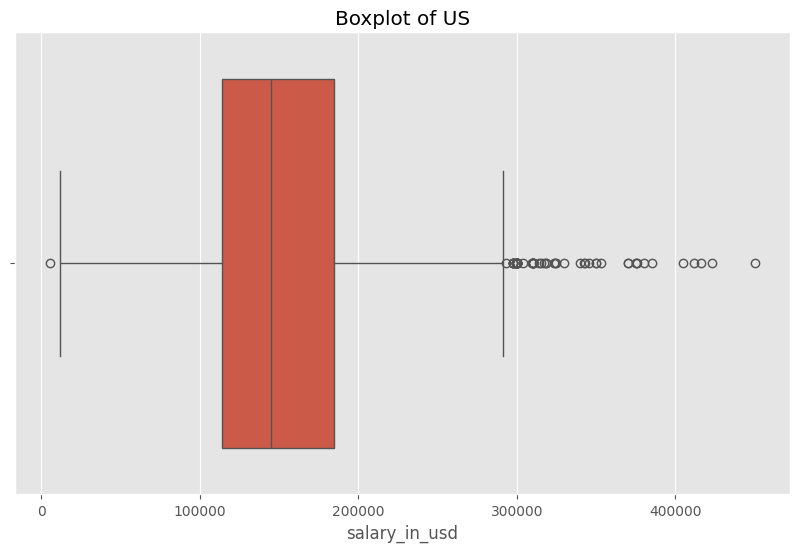

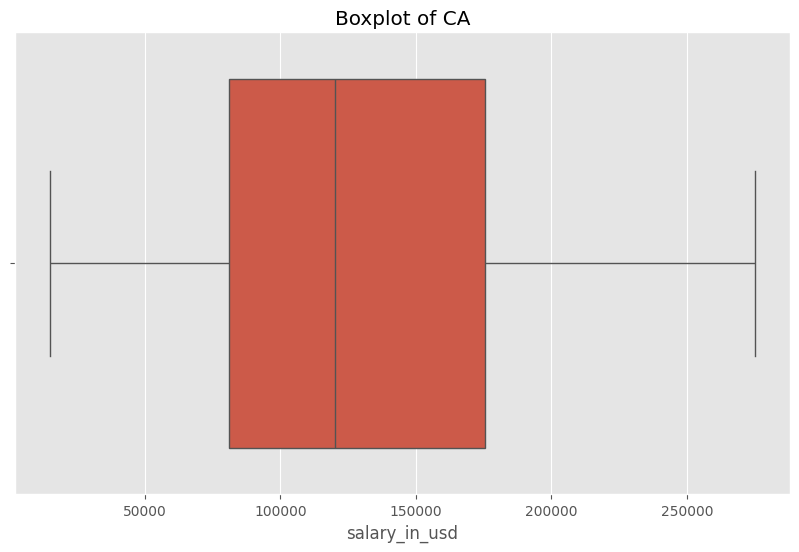

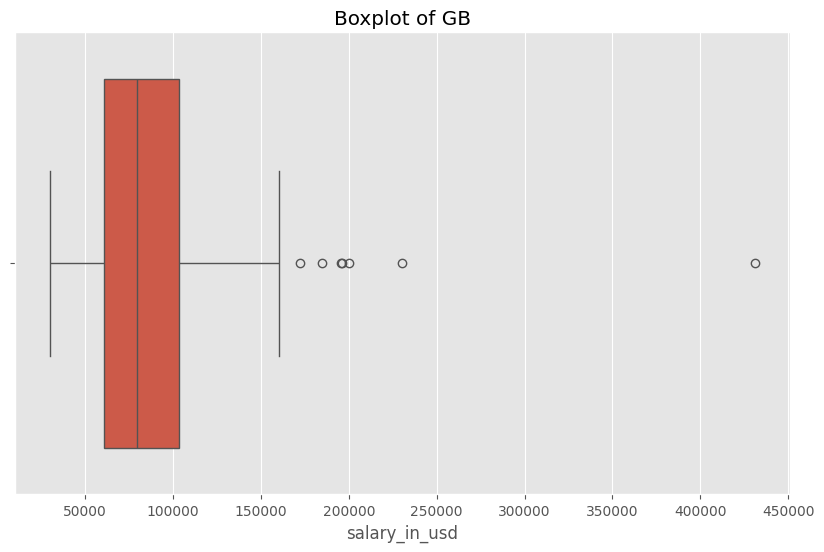

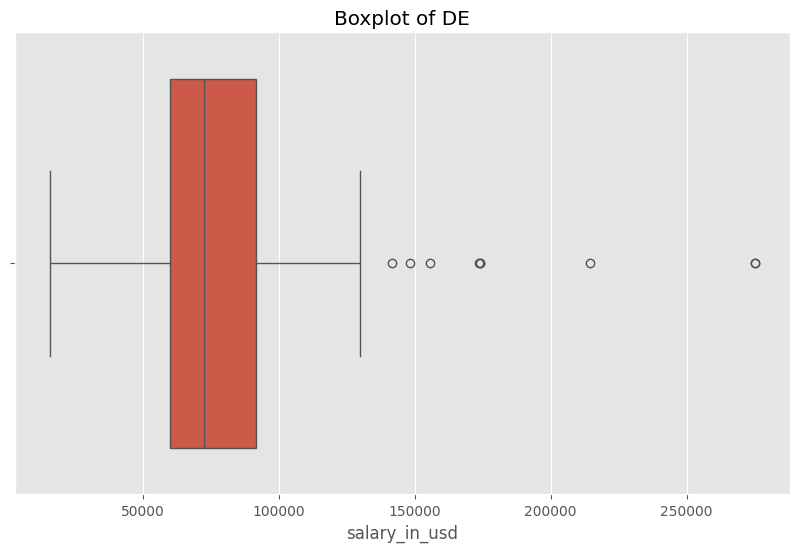

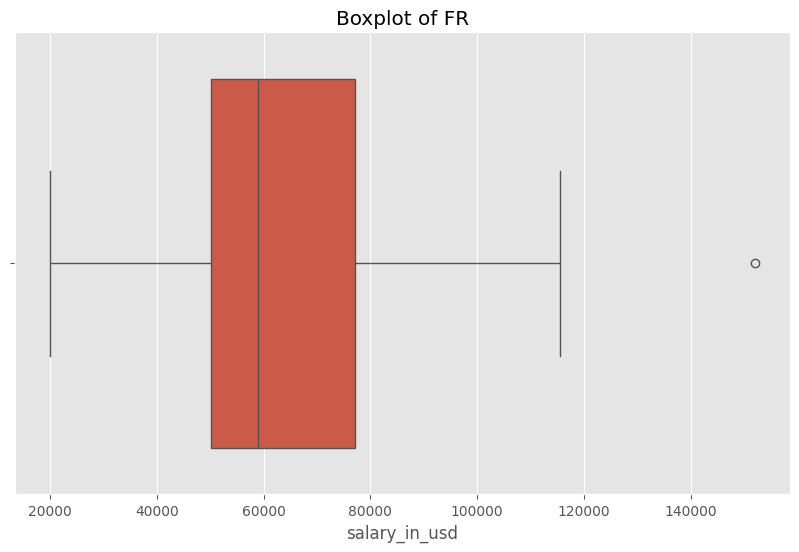

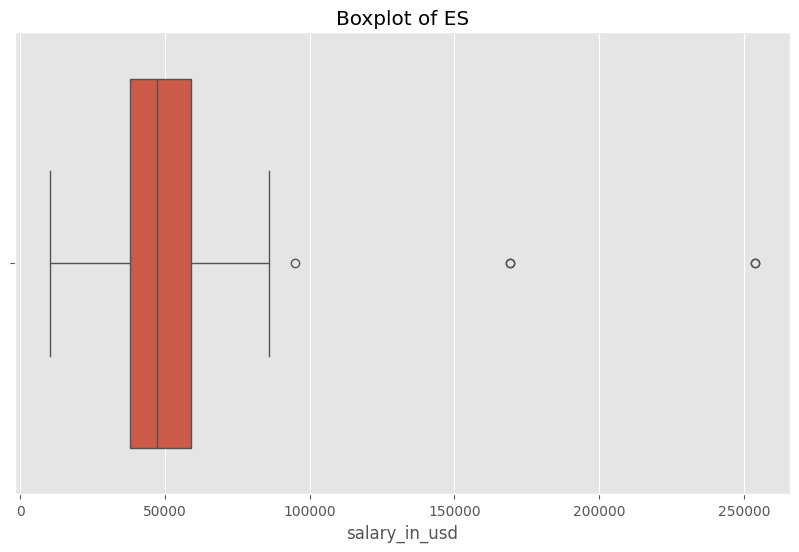

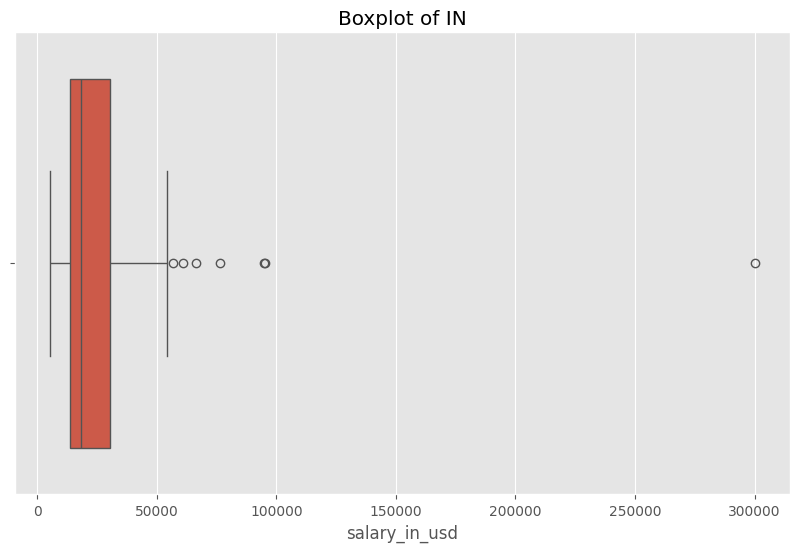

In [165]:
#Mirando como están distribuidos los salarios con boxplots

def make_boxplots(df, column, tag_list):
  for tag in tag_list:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="salary_in_usd", data=df_codified[df_codified[column] == tag])
    plt.title(f'Boxplot of {tag}')
    plt.show()

country_codes = ['US', 'CA', 'GB', 'DE', 'FR', 'ES', 'IN']

make_boxplots(df_codified, 'company_location', country_codes)

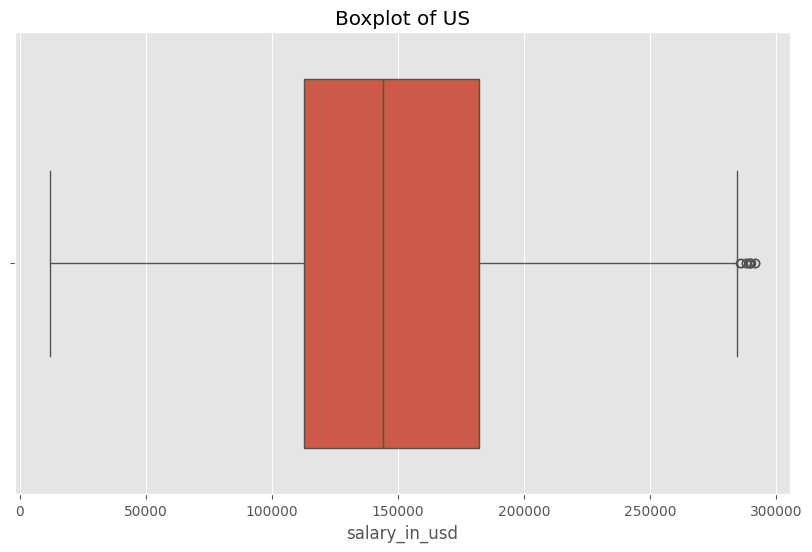

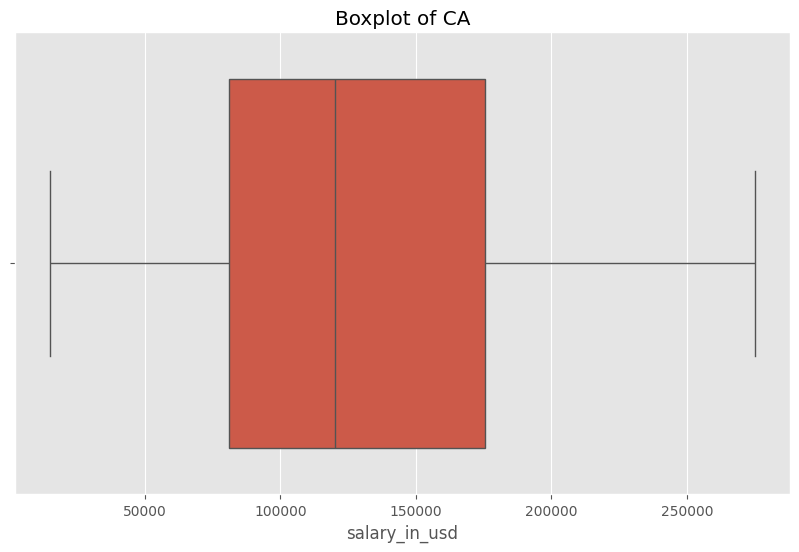

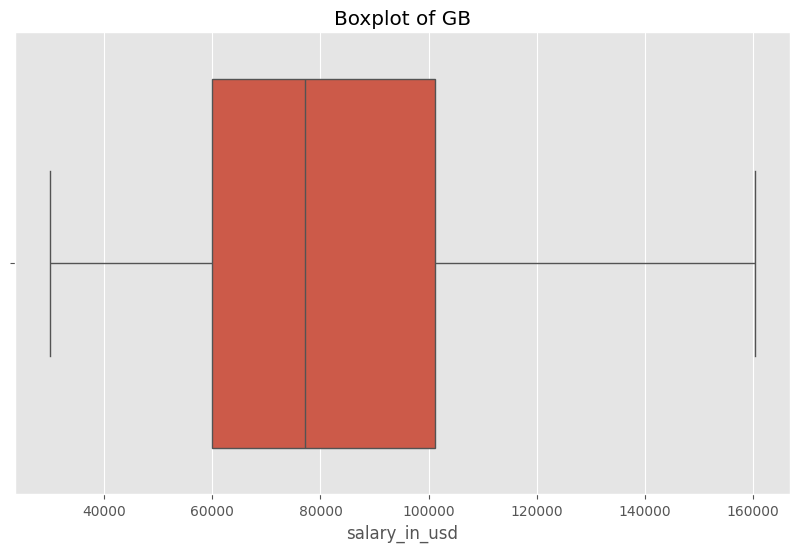

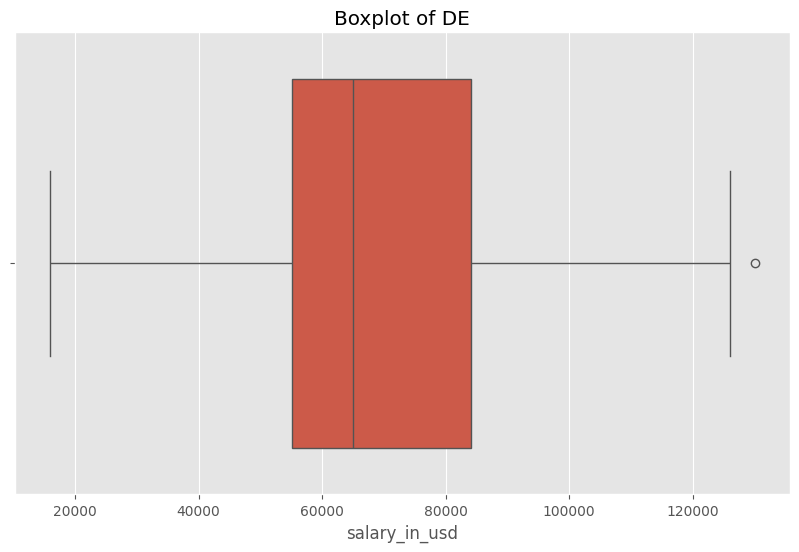

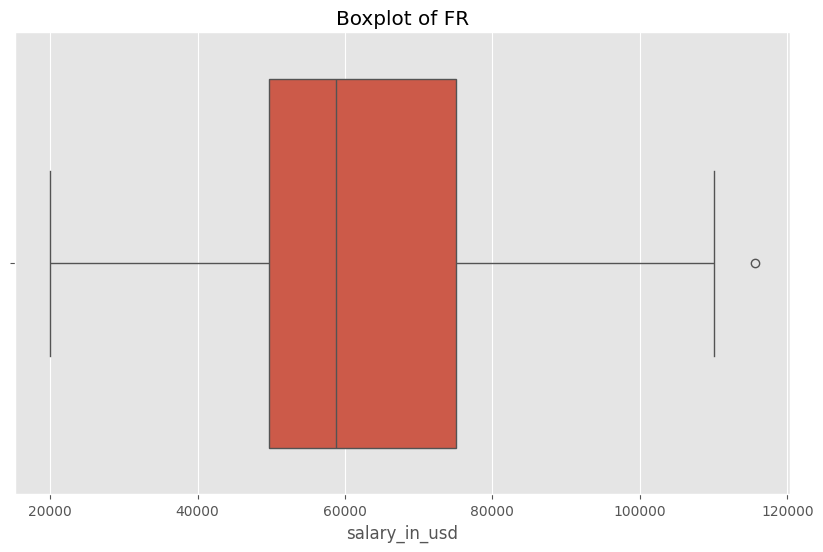

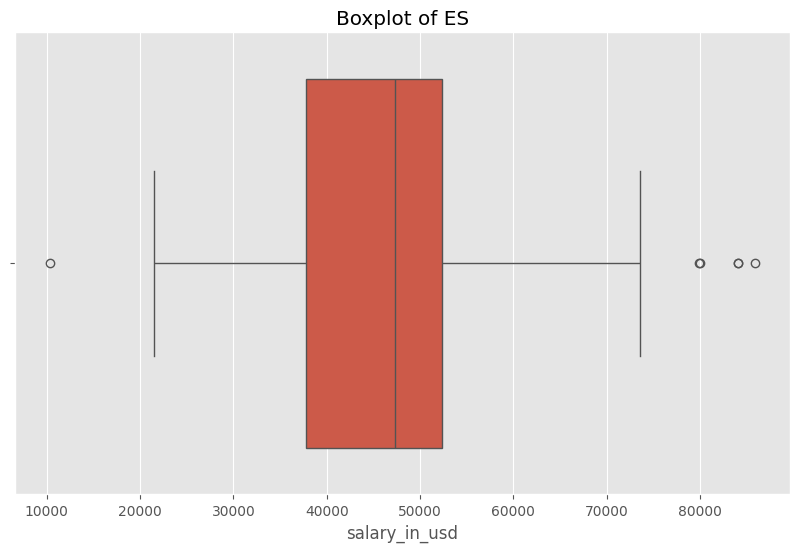

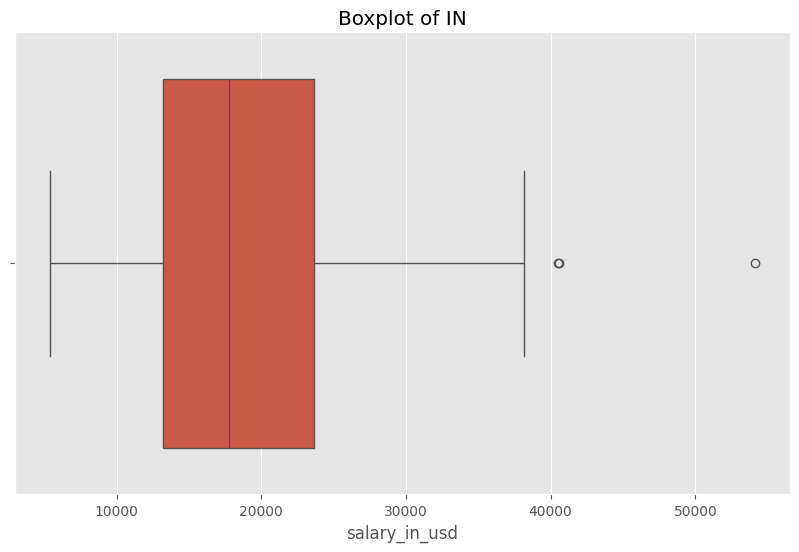

In [166]:
#Borrando los outliers de cada país utilizando el IQR

def remove_outliers(df, column, tag_list):
  df2 = pd.DataFrame()
  for tag in tag_list:
      df1 = df[df[column] == tag]
      Q1 = df1['salary_in_usd'].quantile(0.25)
      Q3 = df1['salary_in_usd'].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      df1 = df1[(df1['salary_in_usd'] >= lower_bound) & (df1['salary_in_usd'] <= upper_bound)]
      df2 = pd.concat([df2, df1])
  return df2

df_codified = remove_outliers(df_codified, 'company_location', country_codes)

make_boxplots(df_codified, 'company_location', country_codes)

In [167]:
#Ignorando los datos bastante lejos de la media de cada país, parece que los salarios van de menos a más altos en este orden:
# USA > CA > GB > DE > ES > IN

df_codified['company_location'] = df_codified['company_location'].map({'US': 7, 'CA': 6, 'GB': 5, 'DE': 4, 'FR': 3, 'ES': 2, 'IN': 1})
df_codified.head()

,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1,3,CT,ML Engineer,30000,US,100,7,1
2,3,CT,ML Engineer,25500,US,100,7,1
5,4,FT,Applied Scientist,222200,US,0,7,3
6,4,FT,Applied Scientist,136000,US,0,7,3
9,4,FT,Data Scientist,147100,US,0,7,2


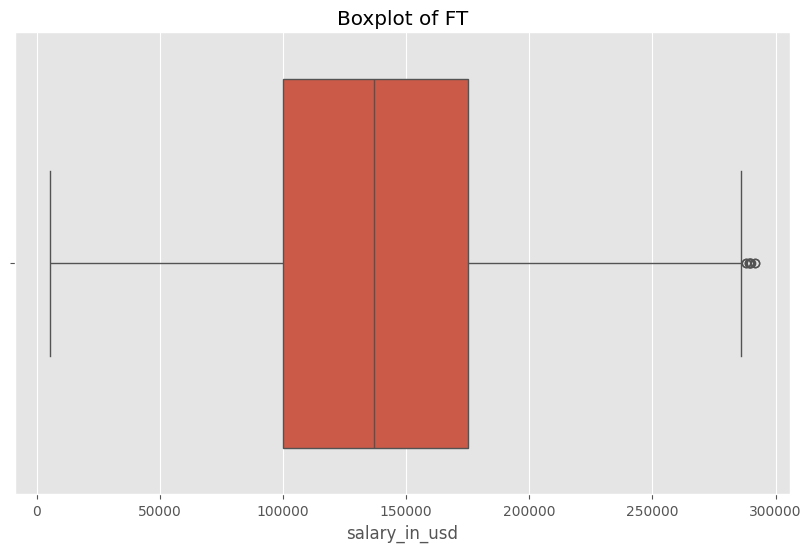

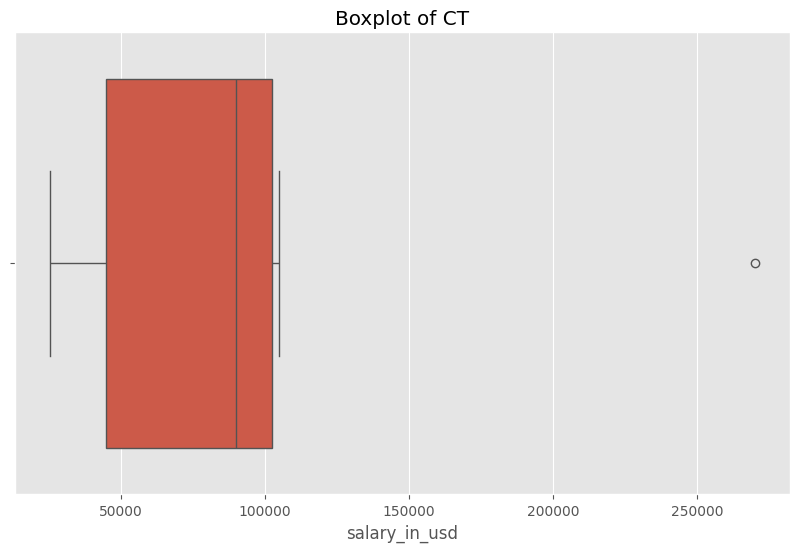

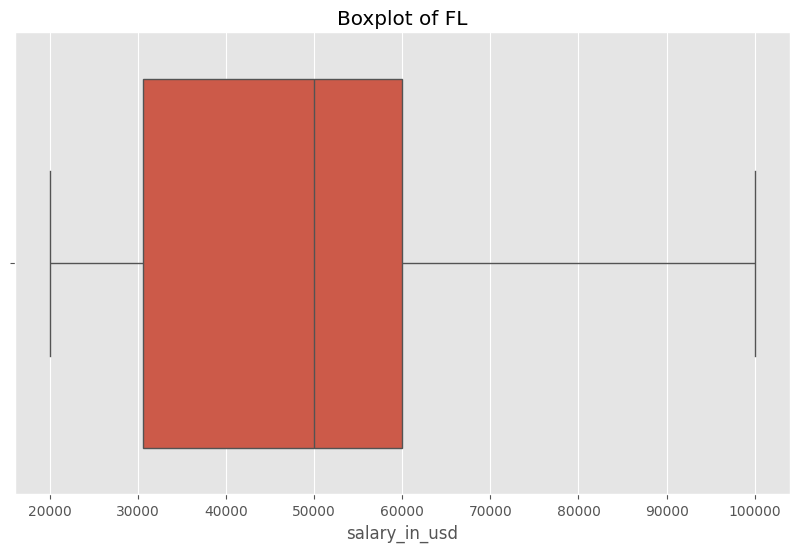

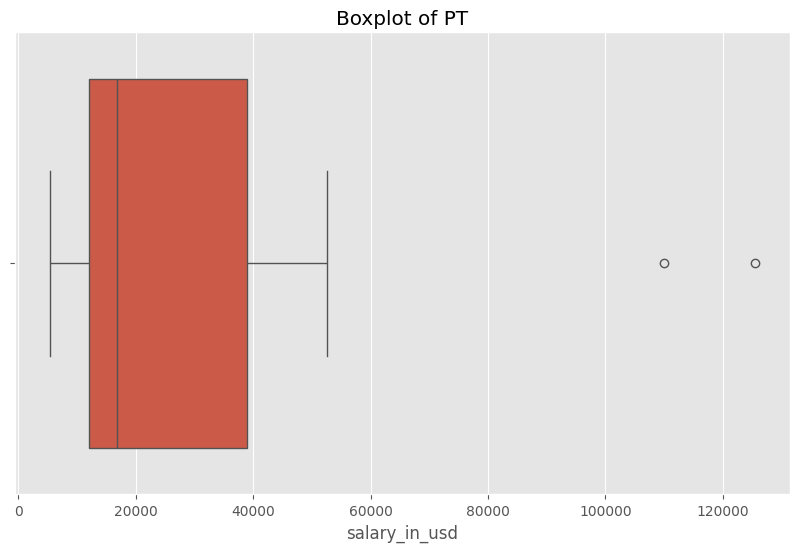

In [168]:
#Revisando la distribución de los registros para cada tipo de empleo
make_boxplots(df_codified, 'employment_type', ['FT', 'CT', 'FL', 'PT'])


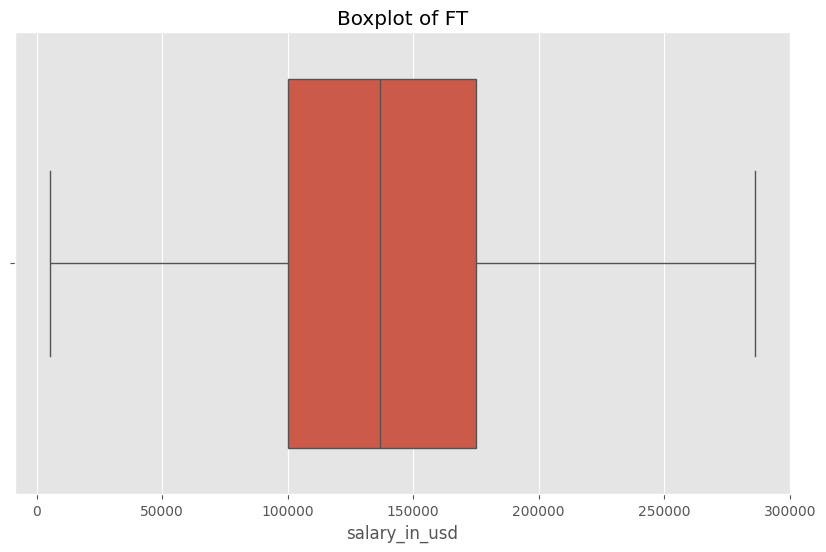

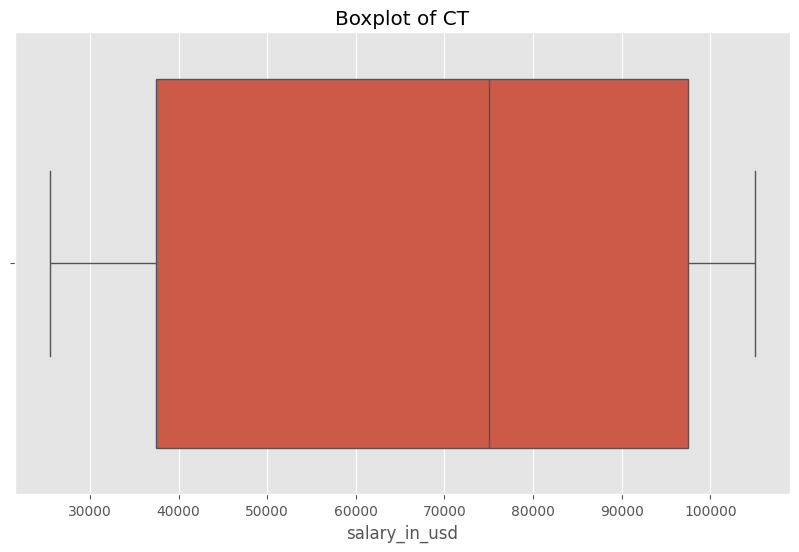

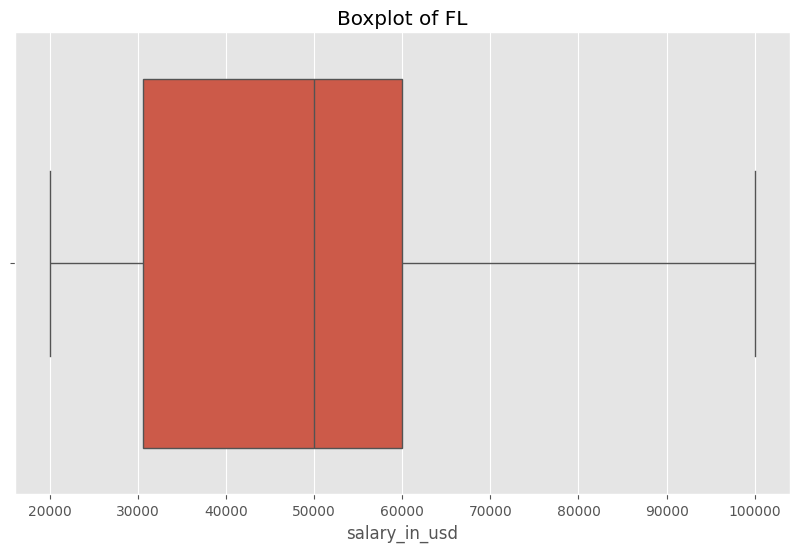

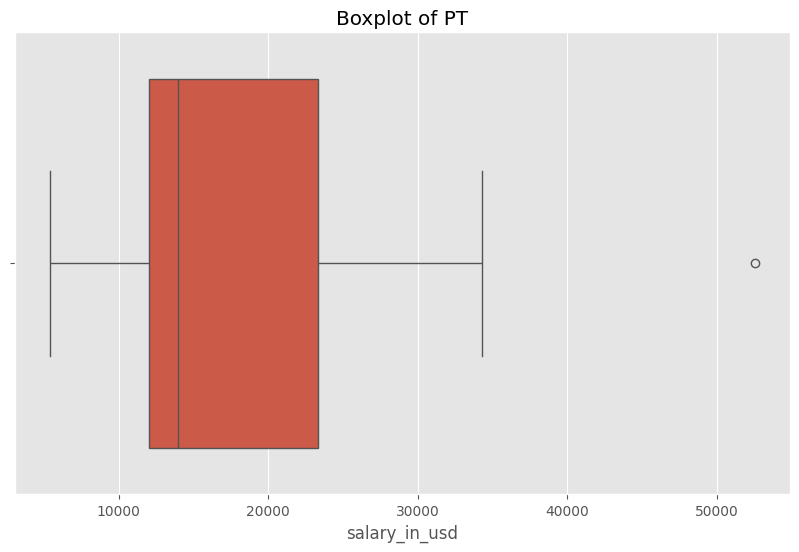

In [169]:
#Eliminando outliers y volviendo a graficar los boxplots
df_codified = remove_outliers(df_codified, 'employment_type', ['FT', 'CT', 'FL', 'PT'])
make_boxplots(df_codified, 'employment_type', ['FT', 'CT', 'FL', 'PT'])

In [170]:
df_codified['employment_type'] = df_codified['employment_type'].map({"FT": 3, "CT": 4, "FL": 2, "PT": 1})

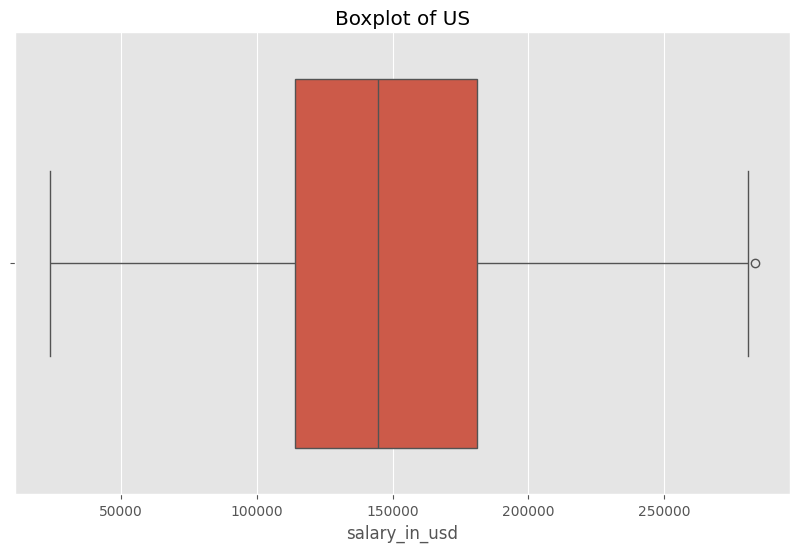

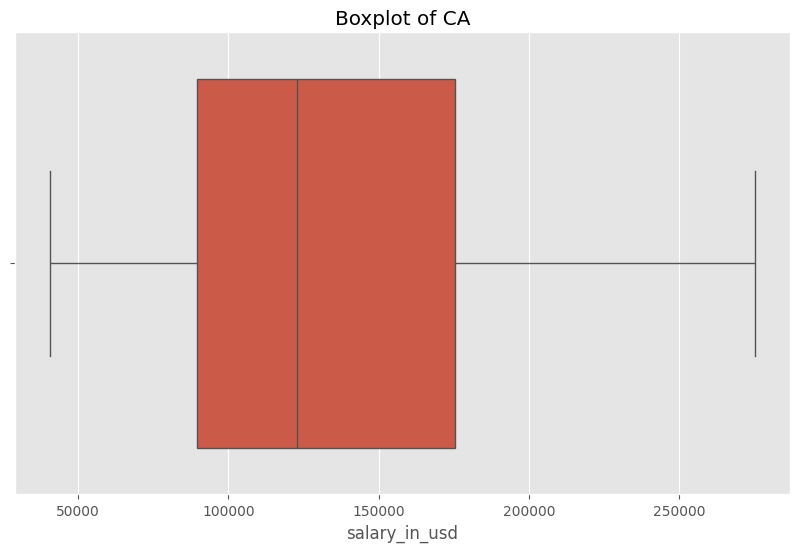

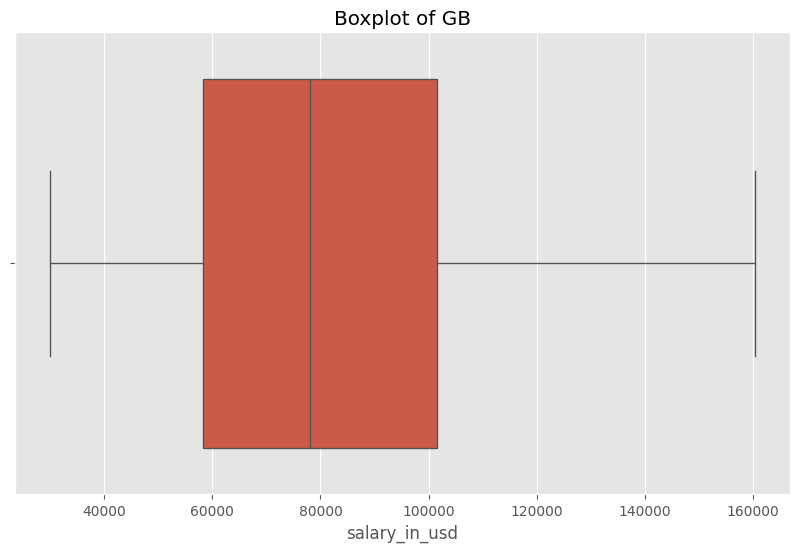

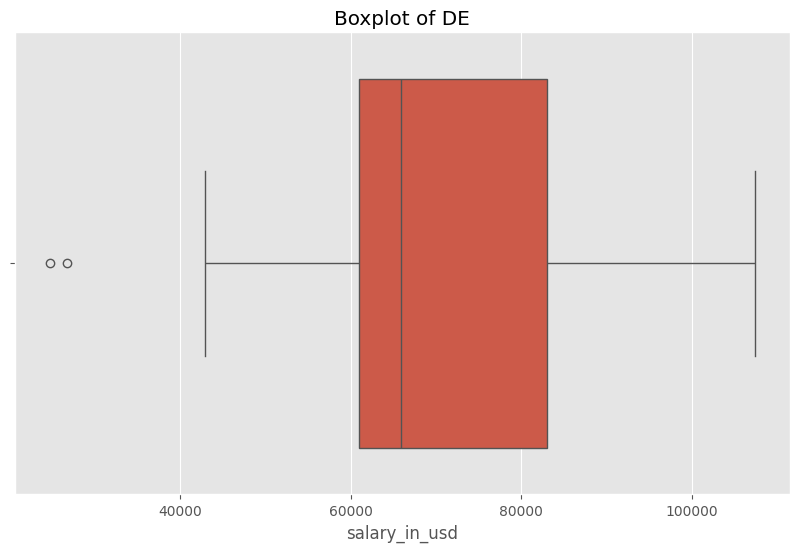

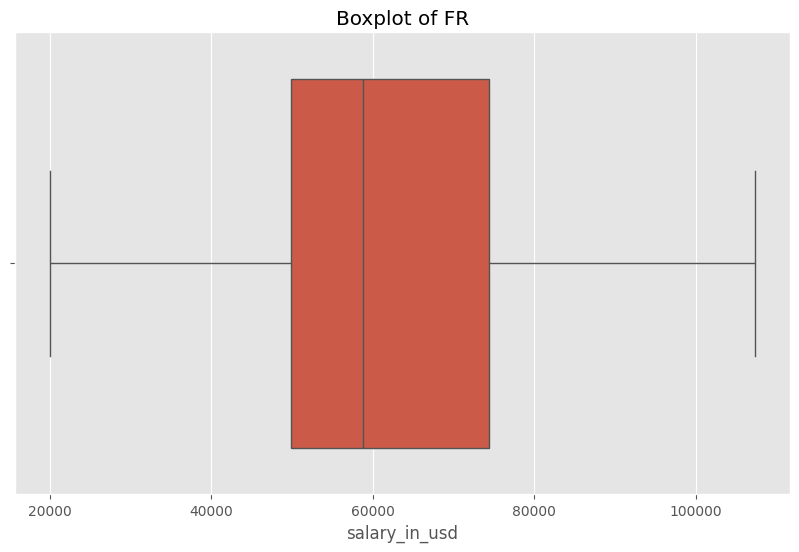

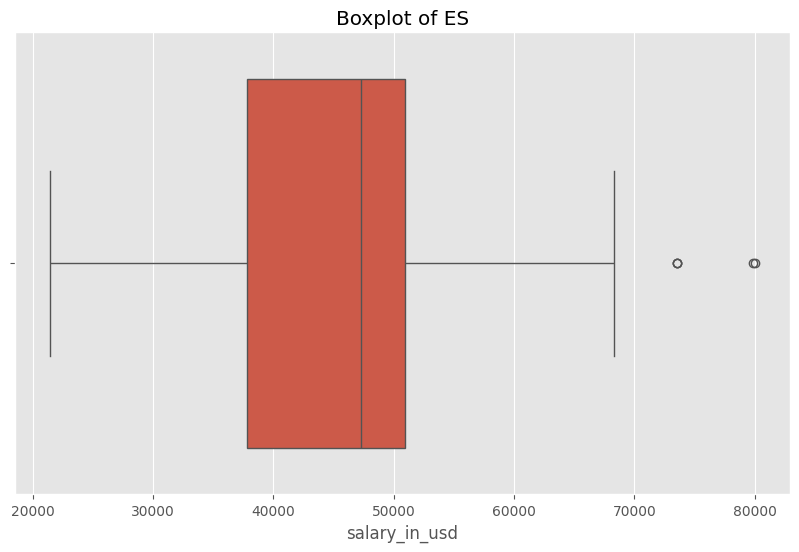

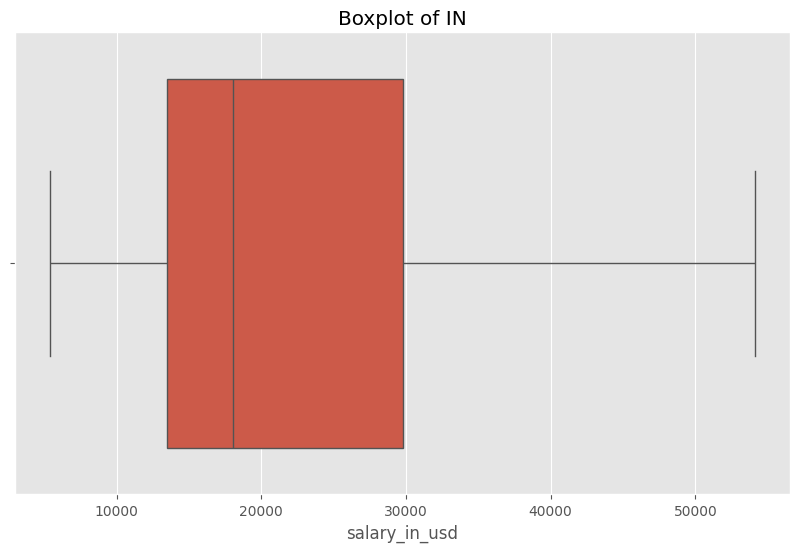

In [171]:
#Mirando cuantos registros tienen los países de residencia
df_codified['employee_residence'].value_counts()

#Los países resultan ser los mismos que los de la ubicacion de las empresas. Voy a hacer lo mismo de antes
top_7 = df['employee_residence'].value_counts()[:7]
df_codified = df_codified[df_codified['employee_residence'].isin(top_7.index)]

#Quitando outliers y haciendo boxplots
df_codified = remove_outliers(df_codified, 'employee_residence', country_codes)
make_boxplots(df_codified, 'employee_residence', country_codes)

In [172]:
#Codificando la variable en base a los salarios promedios

df_codified.groupby('employee_residence')['salary_in_usd'].mean().sort_values(ascending=False)
df_codified['employee_residence'] = df_codified['employee_residence'].map({'US': 7, 'CA': 6, 'GB': 5, 'DE': 4, 'FR': 3, 'ES': 2, 'IN': 1})

In [173]:
#Mirando cuantas posiciones diferentes hay y cuantos registros tiene cada una
df_cod_value_counts = df_codified["job_title"].value_counts()
df_cod_value_counts

#Borrando las posiciones con menos de 37 registros (por ninguna razón, más que ese fue el numero que se escogio para borrar los registros de los países antes)
df_codified = df_codified[df_codified["job_title"].isin(df_cod_value_counts[df_cod_value_counts >= 37].index)]

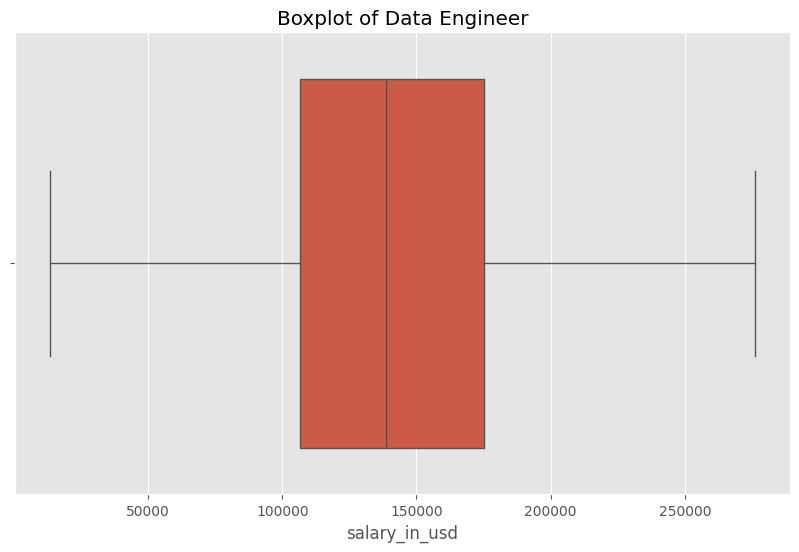

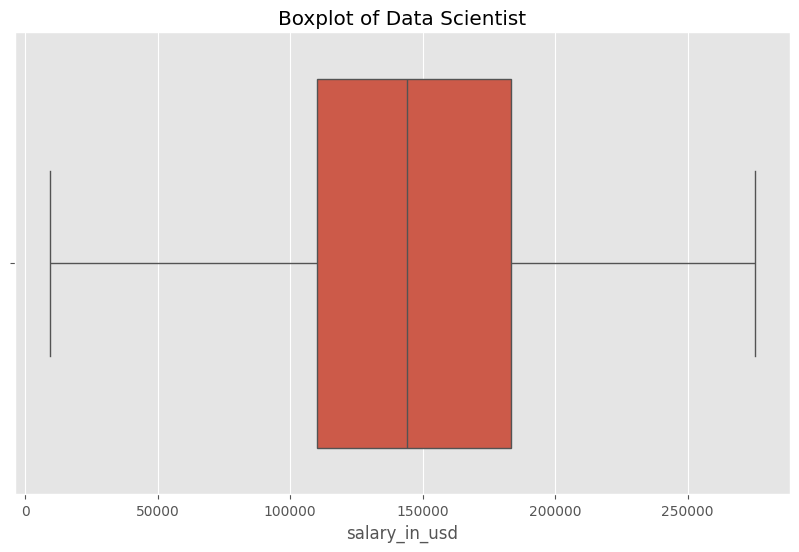

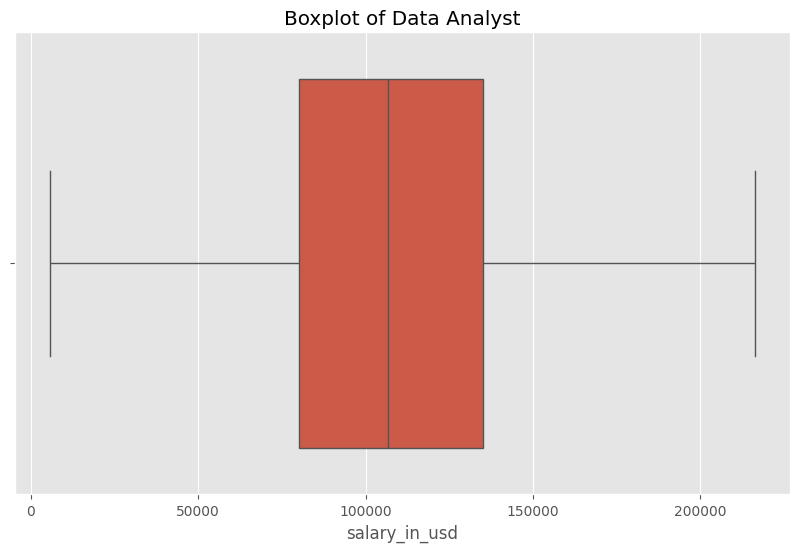

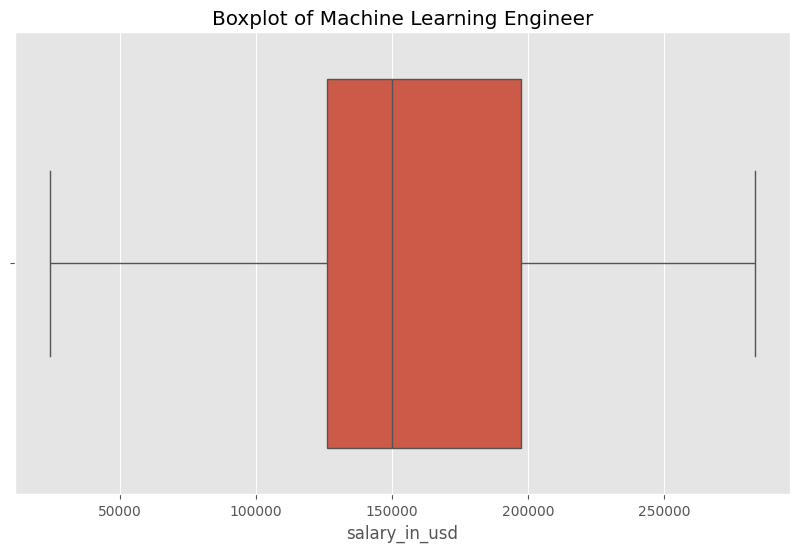

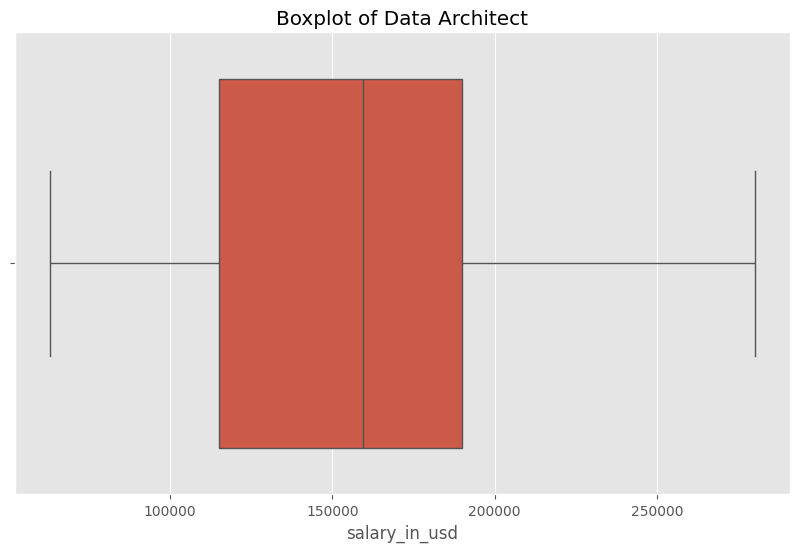

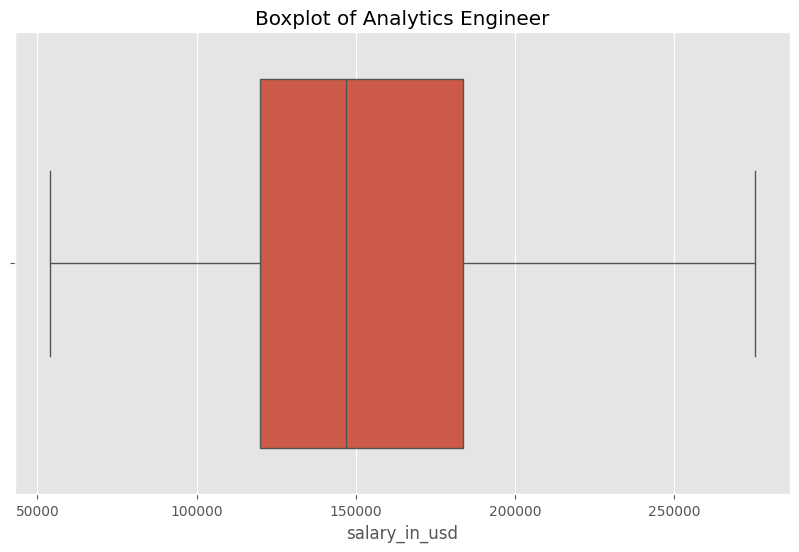

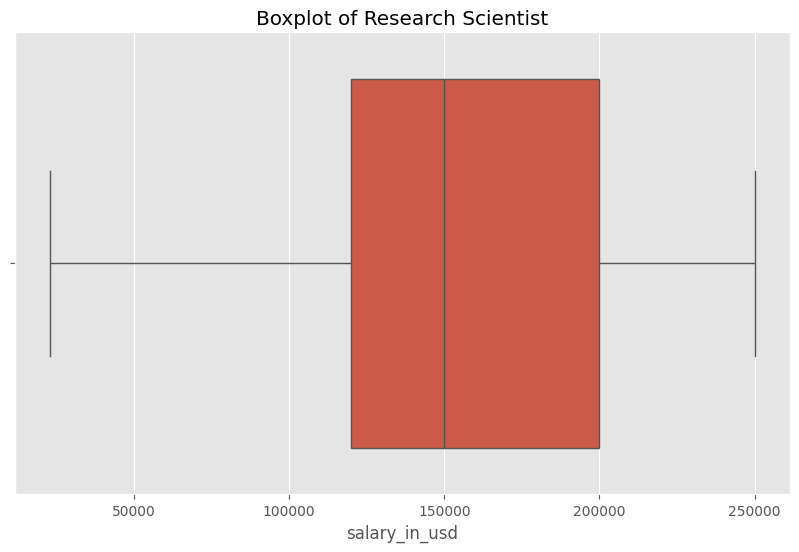

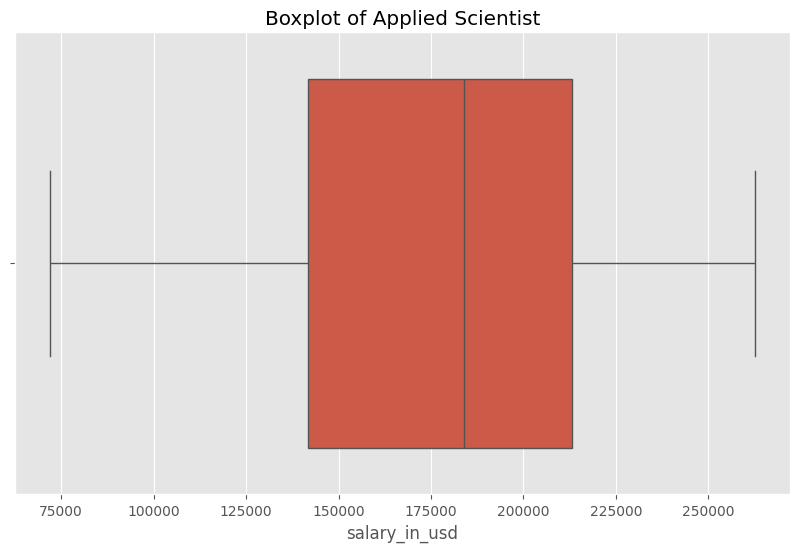

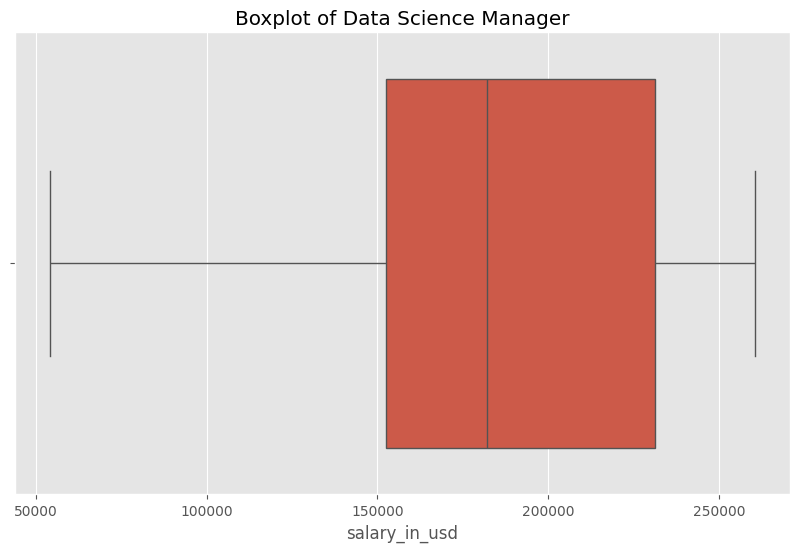

In [174]:
#Removiendo outliers de cada una de las posiciónes y graficando un boxplot para cada una
posiciones = df_codified["job_title"].value_counts().index
df_codified = remove_outliers(df_codified, 'job_title', posiciones)
make_boxplots(df_codified, 'job_title', posiciones)

In [175]:
df_codified

,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
31,4,3,Data Engineer,253200,7,0,7,2
32,4,3,Data Engineer,90700,7,0,7,2
35,3,3,Data Engineer,162500,7,0,7,2
36,3,3,Data Engineer,130000,7,0,7,2
44,4,3,Data Engineer,270703,7,0,7,2
...,...,...,...,...,...,...,...,...
3465,4,3,Data Science Manager,240000,7,0,7,3
3526,4,3,Data Science Manager,144000,7,100,7,3
3654,4,3,Data Science Manager,174000,7,100,7,3
3740,4,3,Data Science Manager,190200,7,100,7,2


In [176]:
#Codifiquemos las posiciones en base al salario promedio de cada una

df_codified.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False)
df_codified['job_title'] = df_codified['job_title'].map({'Data Science Manager': 9, 'Applied Scientist': 8, "Data Architect": 7, "Machine Learning Engineer": 6, "Research Scientist": 5,
                                                         "Analytics Engineer": 4, "Data Scientist": 3,  "Data Engineer": 2, "Data Analyst": 1})

In [177]:
#Quitando outliers de remote_ratio y las demas variables que faltaban
df_codified = remove_outliers(df_codified, 'remote_ratio', [0, 50, 100])
df_codified = remove_outliers(df_codified, 'experience_level', [1, 2, 3, 4, 5])
df_codified = remove_outliers(df_codified, 'company_size', [1, 2, 3])

In [178]:
#Ordenando el DF

df_codified = df_codified[['salary_in_usd', 'job_title', "experience_level", "employment_type", "company_size", "remote_ratio", "company_location", "employee_residence"]]

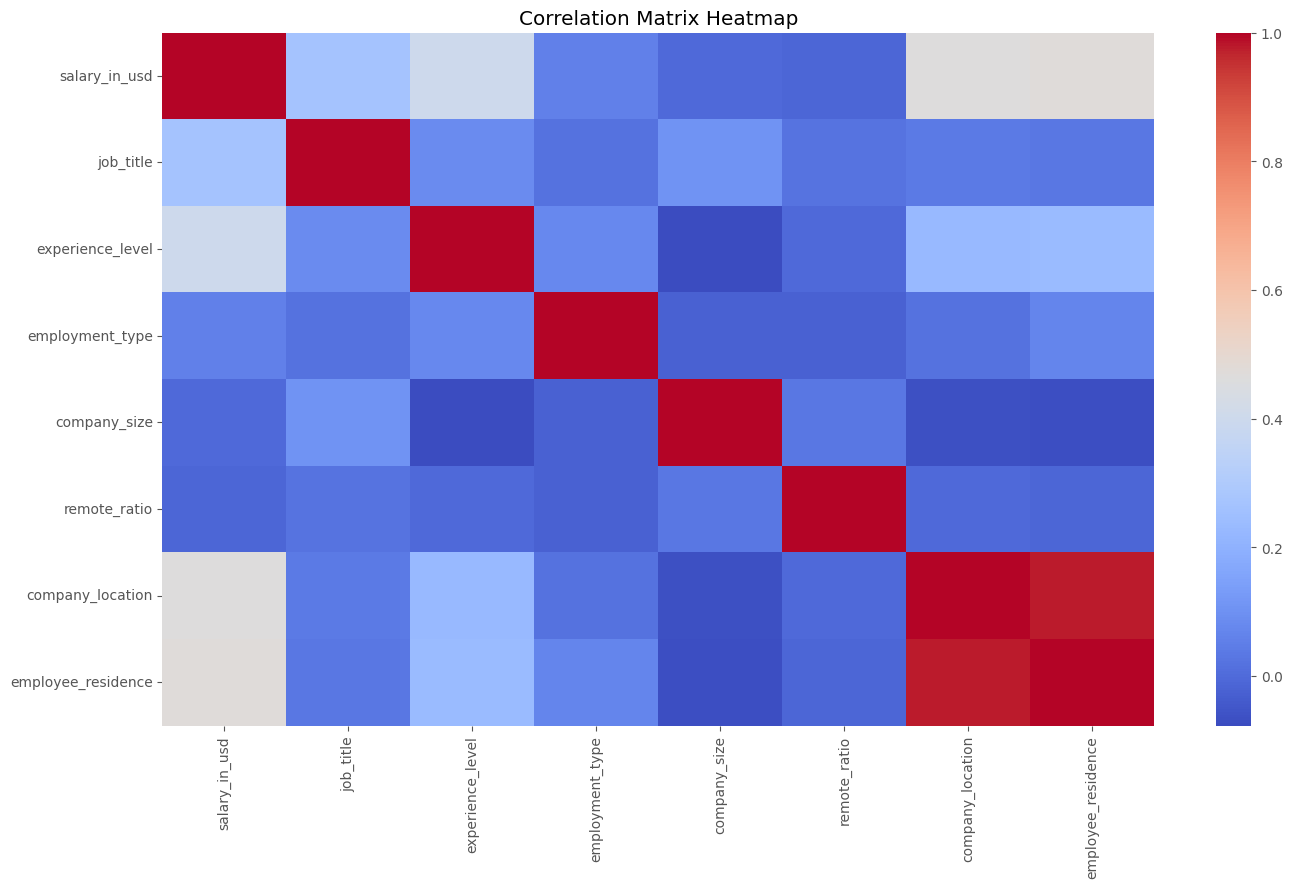

In [179]:
# Calculando la matriz de correlación para ver que las variables independientes que nos quedaron realmente lo sean

correlation_matrix = df_codified.corr()

#Graficandola con un mapa de calor para que sea más facil de ver.

sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.title('Correlation Matrix Heatmap')
plt.show()


In [196]:
#Haciendo la regresión lineal

#Creando las variables predictoras y a predecir. No voy a utilizar company_size, ni remote_ratio, ni employment_type ya que tienen una correlacion muy baja
#Tambien no utilizo company_location ya que esta fuertemente correlacionada con 'employee_residence'
X = df_codified.drop(['salary_in_usd', 'company_size', 'employment_type', 'company_location'],  axis = 1)
y = df_codified['salary_in_usd']

#Creando los sets de prueba y entrenamiento
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#Escalando las variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Importando el modelo
from sklearn.linear_model import LinearRegression

#Creando el modelo
model = LinearRegression()

#Entrenando el modelo
model.fit(X_train, y_train)

#Realizando las predicciones
y_pred = model.predict(X_test)

In [199]:
#Calculating regression metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False)
r2 = model.score(X_test,y_test)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print("R2:",r2)

MAE: 33539.72911189583
MSE: 1717691638.1477377
RMSE: 41445.04358964697
R2: 0.3584747990707077


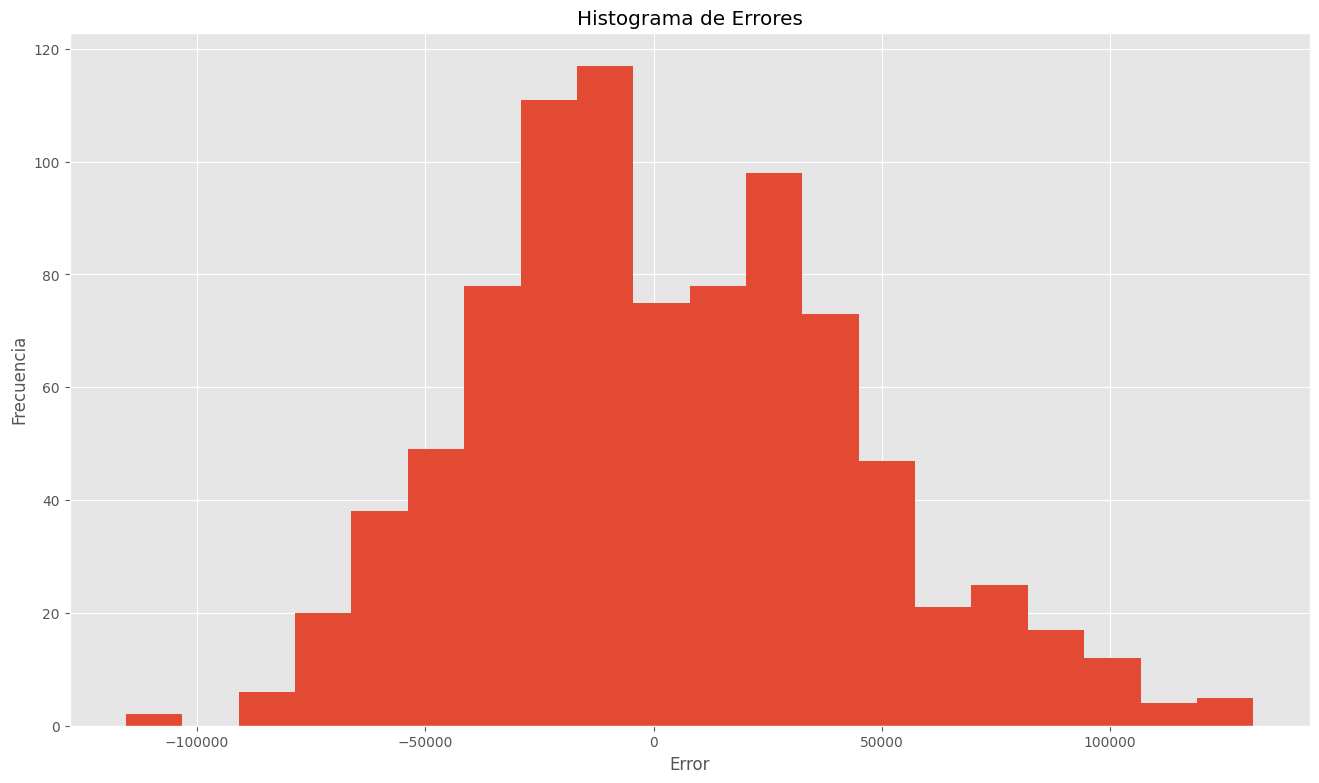

In [200]:
#Graficando un histograma de los errores
error = y_test - y_pred
plt.hist(error, bins=20)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Histograma de Errores')
plt.show()

In [201]:
#Haciendo regresión polinomica
# Importar PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures

# Crear un objeto PolynomialFeatures de grado 2
poly = PolynomialFeatures(degree=2)

# Transformar las variables predictoras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Crear un modelo de regresión lineal
model_poly = LinearRegression()

# Entrenar el modelo con las variables transformadas
model_poly.fit(X_train_poly, y_train)

# Realizar predicciones con las variables transformadas
y_pred_poly = model_poly.predict(X_test_poly)

# Calcular métricas de regresión
mae_poly = mean_absolute_error(y_true=y_test, y_pred=y_pred_poly)
mse_poly = mean_squared_error(y_true=y_test, y_pred=y_pred_poly)
rmse_poly = mean_squared_error(y_true=y_test, y_pred=y_pred_poly, squared=False)
r2_poly = model_poly.score(X_test_poly, y_test)

print("MAE (Polinomial):", mae_poly)
print("MSE (Polinomial):", mse_poly)
print("RMSE (Polinomial):", rmse_poly)
print("R2 (Polinomial):", r2_poly)


MAE (Polinomial): 33484.50468788265
MSE (Polinomial): 1761573950.7424567
RMSE (Polinomial): 41971.108524108065
R2 (Polinomial): 0.38774878380399413
